In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
path = r"Nox/data/imbalance_actual.csv"
df = pd.read_csv(path)

Set correct index and convert to datetime

In [3]:
df.set_index('datetime_utc')
df.index = pd.to_datetime(df.index)

In [4]:
df.describe()

,hour,minute,price_eur_mwh
count,49559.000000,49559.000000,49559.000000
mean,11.498719,22.499546,82.248169
std,6.924319,16.770544,161.377515
min,0.000000,0.000000,-999.000000
25%,5.000000,7.500000,36.410000
50%,11.000000,15.000000,92.000000
75%,18.000000,30.000000,150.000000
max,23.000000,45.000000,2547.850000


In [5]:
df.head()

,datetime_utc,date,hour,minute,price_eur_mwh
1970-01-01 00:00:00.000000000,2024-05-21 22:00:00,2024-05-21,22,0,106.39
1970-01-01 00:00:00.000000001,2024-05-21 22:15:00,2024-05-21,22,15,149.28
1970-01-01 00:00:00.000000002,2024-05-21 22:30:00,2024-05-21,22,30,151.17
1970-01-01 00:00:00.000000003,2024-05-21 22:45:00,2024-05-21,22,45,226.60
1970-01-01 00:00:00.000000004,2024-05-21 23:00:00,2024-05-21,23,0,204.76


In [6]:
df.isna().sum()

datetime_utc     0
date             0
hour             0
minute           0
price_eur_mwh    0
dtype: int64

No missing values

Text(0, 0.5, 'Price_eur_mwh')

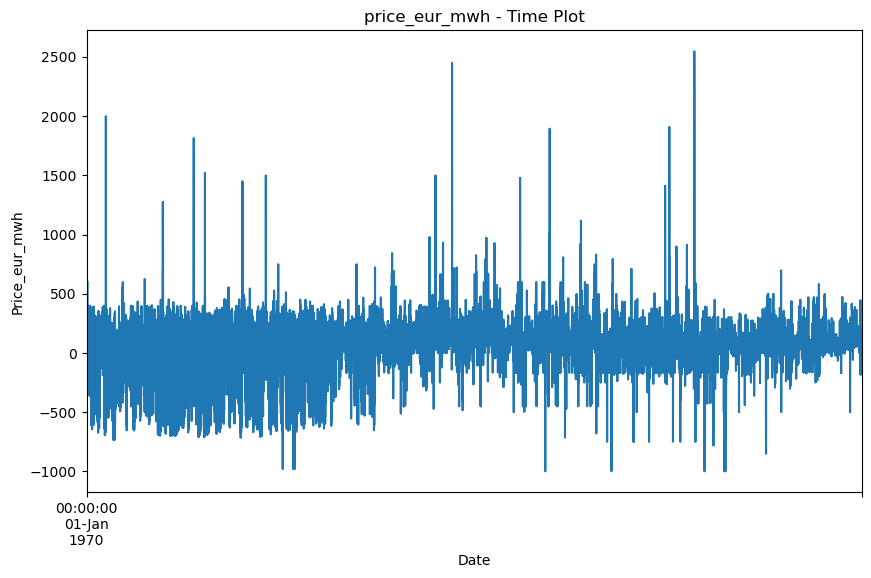

In [8]:
df['price_eur_mwh'].plot(title='price_eur_mwh - Time Plot', figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Price_eur_mwh')